In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from fastapi import FastAPI, HTTPException
import json
import xgboost as xgb
import ast
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna


In [9]:
data = pd.read_csv('ds_challenge_data_2024.csv', encoding='utf-16', on_bad_lines='skip')

In [11]:

def preprocessing(data):
    data_copy = data.copy()
    dispositivo_df = pd.json_normalize(data_copy['dispositivo'].apply(ast.literal_eval))
    data_copy = pd.concat([data_copy, dispositivo_df], axis=1)
    data_copy['fecha'] = pd.to_datetime(data_copy['fecha'])
    data_copy['day_of_week'] = data_copy['fecha'].dt.day_name()
    data_copy['day_of_month'] = data_copy['fecha'].dt.day
    data_copy['porcentaje_cashback'] = data_copy['cashback'] / data_copy['monto']
    data_copy['antiguedad_celular']= datetime.now().year - data_copy['año']
    object_columns = data_copy.select_dtypes(include=['object']).columns
    data_copy[object_columns] = data_copy[object_columns].astype('category')
    data_copy.drop(['fecha', 'dispositivo', 'cashback', 'transaction_id','año'], axis=1, inplace=True)
    for col in data_copy.columns:
        if data_copy[col].dtype not in [float, 'category']:
            data_copy[col] = data_copy[col].astype(float)
    
    

    return data_copy


In [12]:
data_prep= preprocessing(data)

C:\Users\valea\AppData\Local\Temp\ipykernel_692\4234403011.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_copy['fecha'] = pd.to_datetime(data_copy['fecha'])


In [13]:

target = 'fraude'  
X = data_prep.drop(columns=[target])
y = data_prep[target]
y = y.astype('category').cat.codes

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)


In [21]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': trial.suggest_loguniform('eta', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 1e-1),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e-1),
        'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1, 10)
    }
    
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
        
        model = xgb.train(params, dtrain, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)
        y_pred = model.predict(dval)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    return sum(aucs) / len(aucs)


In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

print('Best hyperparameters: ', study.best_params)
print('Best score: ', study.best_value)

[I 2024-05-25 10:54:56,860] A new study created in memory with name: no-name-feac54b3-949a-4b39-8b61-9972e6212a7f
C:\Users\valea\AppData\Local\Temp\ipykernel_692\913809031.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-4, 1e-1),
C:\Users\valea\AppData\Local\Temp\ipykernel_692\913809031.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e-1),
C:\Users\valea\AppData\Local\Temp\ipykernel_692\913809031.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

Best hyperparameters:  {'eta': 0.06810446754298144, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.07775312414324459, 'subsample': 0.6251833255694769, 'colsample_bytree': 0.5691362104108546, 'lambda': 0.0023758537292925255, 'alpha': 0.001665800528500317, 'scale_pos_weight': 8.633098427927576}
Best score:  0.7466166752777365


In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


Cross-validated ROC AUC: 0.74227
Test ROC AUC: 0.71216


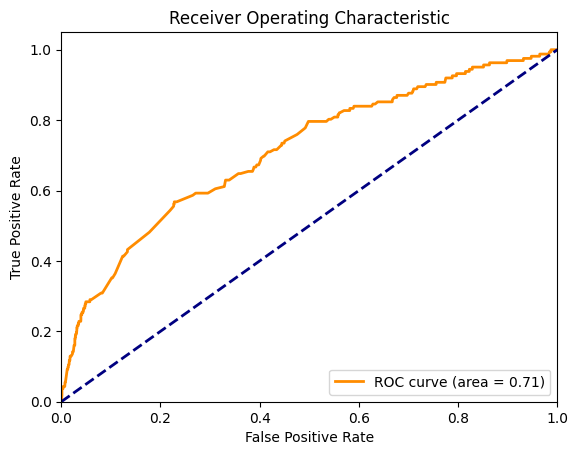

In [24]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


best_params = study.best_params
best_params.update({'objective': 'binary:logistic', 'eval_metric': 'auc'})


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
    X_train_res, y_train_res = undersample.fit_resample(X_train_cv, y_train_cv)
    
    dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv, enable_categorical=True)
    dval_cv = xgb.DMatrix(X_val_cv, label=y_val_cv, enable_categorical=True)
    
    model = xgb.train(best_params, dtrain_cv, evals=[(dval_cv, 'eval')], early_stopping_rounds=10, verbose_eval=False)
    y_pred_cv = model.predict(dval_cv)
    
    auc = roc_auc_score(y_val_cv, y_pred_cv)
    aucs.append(auc)

final_auc = sum(aucs) / len(aucs)
print(f'Cross-validated ROC AUC: {final_auc:.5f}')
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_res, y_train_res = undersample.fit_resample(X_train, y_train)
dtrain_res = xgb.DMatrix(X_train_res, label=y_train_res, enable_categorical=True)
final_model = xgb.train(best_params, dtrain_res)
y_pred_proba = final_model.predict(dtest)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Test ROC AUC: {roc_auc:.5f}')
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [25]:
import joblib
joblib.dump(final_model, 'model.pkl')

['model.pkl']

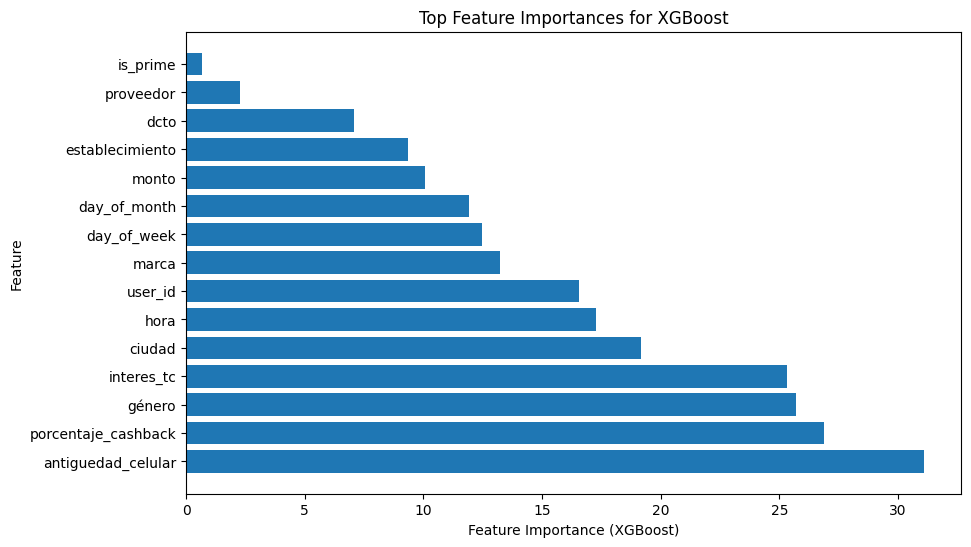

In [26]:


feature_importance_xgb = final_model.get_score(importance_type='gain')
sorted_feature_importance_xgb = sorted(feature_importance_xgb.items(), key=lambda x: x[1], reverse=True)
features_xgb, importances_xgb = zip(*sorted_feature_importance_xgb)plt.figure(figsize=(10, 6))
plt.barh(range(len(features_xgb)), importances_xgb, align='center')
plt.yticks(range(len(features_xgb)), features_xgb)
plt.xlabel('Feature Importance (XGBoost)')
plt.ylabel('Feature')
plt.title('Top Feature Importances for XGBoost')
plt.show()

In [61]:
def PROFIT(true, pred):
    if true + pred == 0: #TRUE POSITIVE 
        return 100
    elif true == 1 and pred == 0: #FALSE NEGATIVE 
        return -500
    else: 
        return 0 

In [62]:
import numpy as np
prof = []
thresholds = np.linspace(0, 1, 100)

for th in thresholds:
    y_pred_num = y_pred_proba >= th
    y_pred_num = [1 if x else 0 for x in y_pred_num]
    prof.append(sum([PROFIT(t, p) for t, p in zip(y_test, y_pred_num)]))

fig = px.line(x=thresholds, y=prof, title="Profit Plot", labels={"x": "Threshold", "y": "Profit"}, template="none")
fig.show()


In [63]:
result = zip(prof, thresholds)
optimal= max(result)[1]
optimal

0.7272727272727273

In [72]:
from sklearn.metrics import confusion_matrix


y_pred = final_model.predict(dtest)


y_pred_classes = (y_pred > 0.7272727272727273).astype(int)  

cm = confusion_matrix(y_test, y_pred_classes)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[5089  144]
 [ 133   29]]
